## Load Packages

In [1]:
using Distributions, Roots, QuadGK

#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Black-Scholes

The Black-Scholes formula for a European call option on an asset with a continuous dividend rate $\delta$

$C  =e^{-\delta m}S\Phi(d_{1}) - e^{-ym}K\Phi(d_{2})$, where

$d_{1} =\frac{\ln(S/K)+(y-\delta+\sigma^{2}/2)m}{\sigma\sqrt{m}} \ \text{ and } \ d_{2}=d_{1}-\sigma\sqrt{m}$ 

and where $\Phi(d)$ denotes the probability of $x\leq d$ when $x$ has an $N(0,1)$ distribution.

In [3]:
function Φ(x)
    #Calculates Pr(z<=x) for N(0,1) variable z
    Pr = cdf(Normal(0,1),x)
    return Pr
end

function OptionBlackSPs(S,K,m,y,σ,δ=0,PutIt=false)
    #Calculates Black-Scholes European call or put option price, continuous dividends of δ
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    c  = exp(-δ*m)*S*Φ(d1) - K*exp(-y*m)*Φ(d2)
    if PutIt 
        price = c - exp(-δ*m)*S + exp(-y*m)*K    
    else     
        price = c
    end    
    return price      
end

OptionBlackSPs (generic function with 3 methods)

In [4]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

C = OptionBlackSPs(S,K,m,y,σ)
printlnPs("\n","call price at K=$K: ",C)

P = OptionBlackSPs(S,K,m,y,σ,0,true)
printlnPs("\n","put price at K=$K:  ",P)

δ = 0.05
Pδ = OptionBlackSPs(S,K,m,y,σ,δ,true)
printlnPs("\n","put price at K=$K and with δ=$δ: ",Pδ)


call price at K=42:      2.893

put price at K=42:       1.856

put price at K=42 and with δ=0.05:      2.309


In [5]:
KM = 30:60
C_K = OptionBlackSPs.(S,KM,m,y,σ)        #at different strike prices 

SM = 30:60
C_S = OptionBlackSPs.(SM,K,m,y,σ)        #at different spot prices

println("let's plot it")

let's plot it


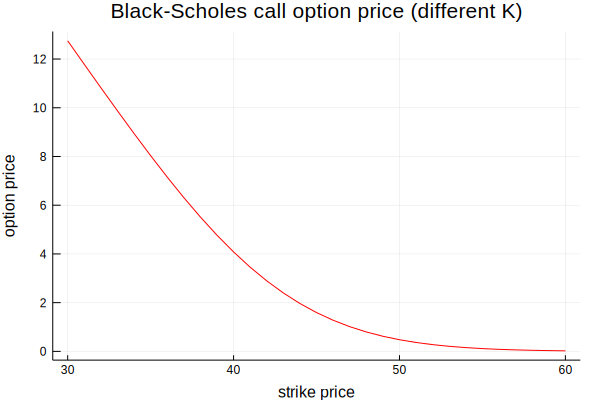

In [6]:
plot(KM,C_K,color=:red,legend=false)
title!("Black-Scholes call option price (different K)")
xlabel!("strike price")
ylabel!("option price")

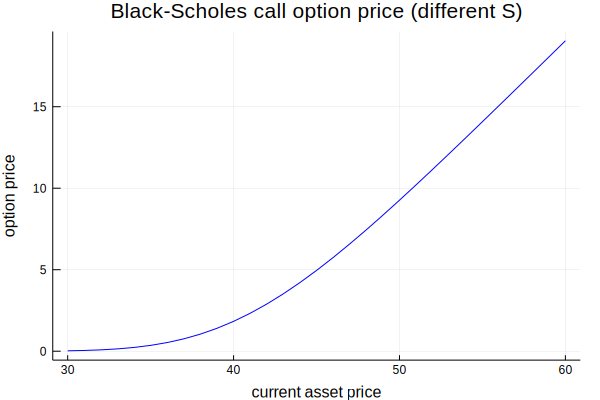

In [7]:
plot(SM,C_S,color=:blue,legend=false)
title!("Black-Scholes call option price (different S)")
xlabel!("current asset price")
ylabel!("option price")

# Implied Volatility

Idea: use an observed option price and solve the BS formula for the unknown $\sigma$

In [8]:
σM = 0.01:0.01:0.3                       #S,K,m,y are scalars, σM is a vector 

C_σ = OptionBlackSPs.(S,K,m,y,σM)        #at different strike prices

println("let's plot it")

let's plot it


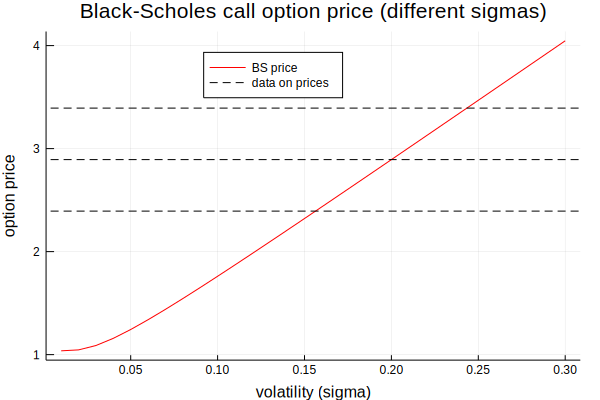

In [9]:
plot(σM,C_σ,color=:red,label="BS price")
title!("Black-Scholes call option price (different sigmas)")
xlabel!("volatility (sigma)")
ylabel!("option price")
plot!([C;C+0.5;C-0.5],linetype=:hline,linecolor=:black,line=(:dash,1),label="data on prices ",legend=:top)

In [10]:
println("Compare the following results with the previous graph\n")

iv = find_zero(sigma->OptionBlackSPs(S,K,m,y,sigma)-C,(-1,1))
printlnPs("Implied volatility (same as above?):     ",iv)

iv_a = find_zero(sigma->OptionBlackSPs(S,K,m,y,sigma)-(C+0.5),(-1,1))
printlnPs("Implied volatility (overpriced option):  ",iv_a)

iv_b = find_zero(sigma->OptionBlackSPs(S,K,m,y,sigma)-(C-0.5),(-1,1))
printlnPs("Implied volatility (underpriced option): ",iv_b)

Compare the following results with the previous graph

Implied volatility (same as above?):          0.200
Implied volatility (overpriced option):       0.243
Implied volatility (underpriced option):      0.156


# BS from an Explicit Integration

The price of a European a call option is 

$
C=e^{-ym}\text{E}^{\ast}\int_{0}^{\infty}\max(0,S_{m}-K),
$

which can be written

$
C=e^{-ym}\int_{0}^{\infty}\max(0,S_{m}-K)  f^{\ast}(S_{m})dS_{m}.
$

where $f^{\ast}(S_{m})$ is the risk neutral density function of the asset
price at expiration ($S_{m}$). (The spot price cannot go below zero.)

(Clearly, we could integrate over $[K,\infty)$ instead. Also, for that
region, $\max(0,S_{m}-K)$ can be replaced by $S_{m}-K$.)

In the Black-Scholes model, the (physical) normal distribution for the log
asset price implies that the risk neutral distribution of $\ln S_{m}$ is

$
\ln S_{m}\sim^{\ast}\text{N}(\ln S+ym-\sigma^{2}m/2,\sigma^{2}m),
$

where $S$ is the current asset price.

In [11]:
function BSintegrand(Sm,S,K,y,m,σ)        #integratre to get Black-Scholes call price
    μ = log(S) + y*m - m*σ^2/2            #"mean" of log-normal
    f = pdf(LogNormal(μ,sqrt(m)*σ),Sm)    #log-normal pdf 
    z =  exp(-y*m)*max(0,Sm-K)*f
    return z 
end

BSintegrand (generic function with 1 method)

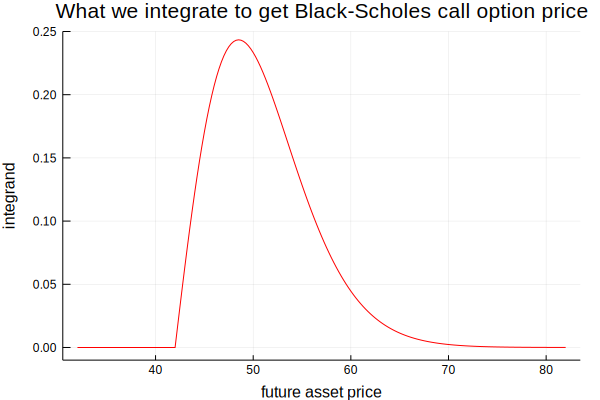

In [12]:
Sm = (K-10):0.25:(K+40)

plot(Sm,BSintegrand.(Sm,S,K,y,m,σ),color=:red,ylim=(-0.01,0.25),legend=false)
title!("What we integrate to get Black-Scholes call option price")
xlabel!("future asset price")
ylabel!("integrand")

In [13]:
C1, = QuadGK.quadgk(x->BSintegrand(x,S,K,y,m,σ),0,Inf)

printlnPs("\nCall price according to integration of risk-neutral dist: ",C1)

printlnPs("\nCompare with the result from the BS formula (from above): ",C)


Call price according to integration of risk-neutral dist:      2.893

Compare with the result from the BS formula (from above):      2.893


# Convergence of BOPM to BS

Idea: calculate the option price according to binomial model with a CRRA calibration where $u=e^{\sigma\sqrt{h}}\text{ and }d=e^{-\sigma\sqrt{h}}$. Keeping the time to expiration $m$ fixed, try using more and more time steps ($n$), but recall that $h=m/n$

### From Chapter on Binominal Model

In [14]:
function BuildSTree(S,n,u,d)
    STree = [fill(NaN,i) for i = 1:n+1]  #vector of vectors (of different lengths)
    STree[1][1] = S                      #time node 1, element 1 
    for i = 2:n+1                        #move forward in time
        STree[i][1:end-1] = u*STree[i-1]   #up move from STree[i-1][1:end]
        STree[i][end] = d*STree[i-1][end]  #down move from STree[i-1][end] 
    end
    return STree    
end

function EuOptionPrice(STree,K,y,n,h,u,d,p,isPut=false)     #price of European option
    Value = deepcopy(STree)                          #tree for derivative, to fill
    if isPut 
        Value[n+1] = max.(0,K.-STree[n+1])            #put, at last time node
    else
        Value[n+1] = max.(0,STree[n+1].-K)            #call, at last time node    
    end    
    for i = n:-1:1                                   #move backward in time
        Value[i] = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
    end                                           #p*up + (1-p)*down, discount   
    return Value
end

EuOptionPrice (generic function with 2 methods)

In [15]:
#(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

nMax = 200

CeM = fill(NaN,nMax)
for n = 1:nMax
    local h, u, d, p, STree, Ce
    h = m/n                 #time step size (in years)
    u = exp(σ*sqrt(h))
    d = exp(-σ*sqrt(h))
    p = (exp(y*h) - d)/(u-d)
    STree = BuildSTree(S,n,u,d)
    Ce = EuOptionPrice(STree,K,y,n,h,u,d,p,false)
    CeM[n] = Ce[1][1]
end   

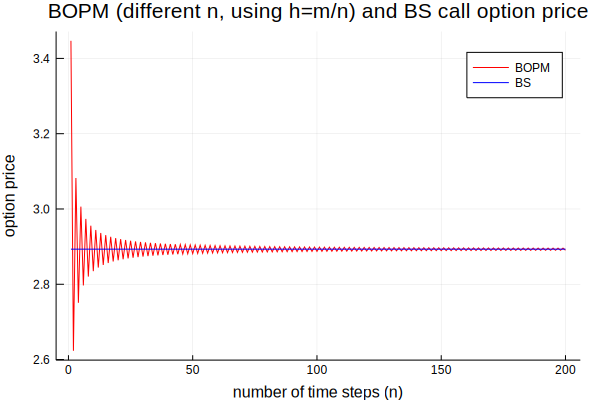

In [16]:
plot(1:nMax,CeM,color=:red,label="BOPM")
plot!(1:nMax,fill(C,nMax),color=:blue,label="BS")
title!("BOPM (different n, using h=m/n) and BS call option price")
xlabel!("number of time steps (n)")
ylabel!("option price")